In [1]:
%load_ext autoreload
%autoreload 2
import os
from datetime import datetime
import fire
import torch
import pandas as pd
from torchtext import data
import torch.nn as nn
from transformers import (
    AdamW, BertForSequenceClassification, BertTokenizer,
    get_constant_schedule_with_warmup
)

from offenseval.nn import (
    Tokenizer,
    train, evaluate, train_cycle, save_model, load_model, evaluate_dataset
)
from offenseval.datasets import datasets
import glob

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


danish_models = glob.glob("../../models/*.da.*.pt")
english_models = glob.glob("../../models/*.olid+da.*.pt")
arabic_models = glob.glob("../../models/*.ar+da.*.pt")

english_models = [m for m in english_models if "95" not in m]
arabic_models = [m for m in arabic_models if "95" not in m]




In [ ]:
english_models, arabic_models

(['../../models/bert_cased.olid+da.25.pt',
  '../../models/bert_cased.olid+da.70.pt',
  '../../models/bert_cased.olid+da.85.pt',
  '../../models/bert_cased.olid+da.65.pt',
  '../../models/bert_cased.olid+da.5.pt',
  '../../models/bert_cased.olid+da.90.pt',
  '../../models/bert_cased.olid+da.80.pt',
  '../../models/bert_cased.olid+da.15.pt',
  '../../models/bert_cased.olid+da.30.pt',
  '../../models/bert_cased.olid+da.20.pt',
  '../../models/bert_cased.olid+da.10.pt',
  '../../models/bert_cased.olid+da.55.pt',
  '../../models/bert_cased.olid+da.50.pt',
  '../../models/bert_cased.olid+da.45.pt',
  '../../models/bert_cased.olid+da.60.pt',
  '../../models/bert_cased.olid+da.35.pt',
  '../../models/bert_cased.olid+da.75.pt',
  '../../models/bert_cased.olid+da.40.pt'],
 ['../../models/bert_cased.ar+da.25.pt',
  '../../models/bert_cased.ar+da.90.pt',
  '../../models/bert_cased.ar+da.80.pt',
  '../../models/bert_cased.ar+da.40.pt',
  '../../models/bert_cased.ar+da.75.pt',
  '../../models/bert_

In [3]:
%%capture
import glob 
import os

danish_only = {}
mixed = {}

device = "cuda"

def eval_models(model_paths, test_path):
    
    ret = {}

    for path in model_paths:
        print(path)
        _, file = os.path.split(path)
        model_name, _ = os.path.splitext(file)
        percentage = int(model_name.split(".")[-1])

        model, TEXT = load_model(path, device)
        model.eval();


        report = evaluate_dataset(
            model, TEXT, test_path,
        )

        ret[percentage] = report.macro_f1
    
    return ret

danish_only = eval_models(danish_models, datasets["danish"]["test"])
english = eval_models(english_models, datasets["danish"]["test"])
arabic = eval_models(arabic_models, datasets["danish"]["test"])


,Danish,English + Danish,Arabic + Danish
5,0.524377,0.626108,0.565115
10,0.540780,0.676330,0.545461
15,0.515362,0.646358,0.640886
20,0.541527,0.688239,0.579323
25,0.633546,0.688385,0.595492
30,0.576105,0.684135,0.657039
35,0.613116,0.709195,0.684187
40,0.661407,0.712245,0.672637
45,0.672637,0.696867,0.686786
50,0.719938,0.702280,0.721488


Text(0, 0.5, 'Macro-F1')

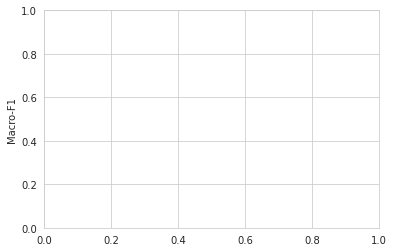

In [12]:
import matplotlib.pyplot as plt
series = pd.Series(danish_only)

df = pd.DataFrame({
    "Danish only": series,
    "English + Danish": english,
    "Arabic + Danish": arabic
})

#df.reset_index().plot(kind="scatter", y="Danish", x="index")
#df.reset_index().plot(kind="scatter", y="English + Danish", x="index")
#df.reset_index().plot(kind="scatter", y="Arabic + Danish", x="index")

df.drop([95, 100], axis=0, inplace=True)

plt.ylabel("Macro-F1")

([<matplotlib.axis.XTick at 0x7f56f307d828>,
 <a list of 10 Text major ticklabel objects>)

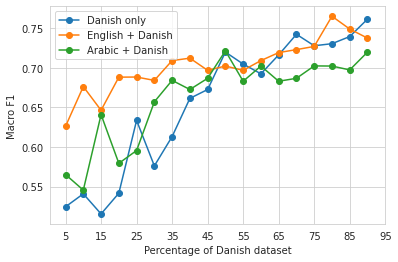

In [13]:
import seaborn as sns

sns.set_style('whitegrid')

df.plot(style="-o")

plt.xlabel("Percentage of Danish dataset")
plt.ylabel("Macro F1")
plt.savefig("few-shot-danish.png")
plt.xticks(list(range(5, 100, 10)))

,Danish,English + Danish
5,0.524377,0.626108
10,0.540780,0.676330
15,0.515362,0.646358
20,0.541527,0.688239
25,0.633546,0.688385
30,0.576105,0.684135
35,0.613116,0.709195
40,0.661407,0.712245
45,0.672637,0.696867
50,0.719938,0.702280
